In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
from bert_score import BERTScorer
warnings.filterwarnings("ignore")
from copy import deepcopy
from openai import OpenAI

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, \
    get_context_length, get_generated_text, FileReader, is_text_in_language, rolling_mean,\
    get_context_length

from src.attention_saver import Mistral7BAttentionSaver
from src.influence import Influence

In [10]:
tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Meta-Llama-3-8B",
    cache_dir = "/Data"    
)

start_of_generation_token = "<|start_header_id|>assistant<|end_header_id|>"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

df = load_dataset("stas/openwebtext-10k", cache_dir= "/Data")['train'].to_pandas()
df["text_len"] = df["text"].apply(lambda x: len(x.split(" ")))

In [9]:
base_instruction = "Summarize in french"
df["context_length"] = (base_instruction + " \n" + df["text"])\
    .apply(get_context_length, tokenizer = tokenizer)

No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.


In [11]:
base_path = "data/Meta-Llama-3-8B-Instruct/checkpoints"
all_results = []
for delta_attention in [0., 0.5, 1., 2.0]:
    for all_layers in ["all", "none"]:
        path = os.path.join(
            base_path,
            f"{all_layers}_layers_generated_delta={delta_attention}.pkl"
        )
        try:
            results_df = pd.read_pickle(path).T

        except Exception as e:
            print(e)
            continue

        parsed_results_dict = dict()

        for epoch in range(len(results_df.columns)-1):
            for (idx, result_epoch) in results_df.loc[:,f"epoch {epoch}"].items():
                s = pd.Series(result_epoch)\
                    .apply(get_generated_text, start_of_generation_token = start_of_generation_token)\

                data = pd.DataFrame(s).T
                data.index = [idx]

                if not epoch in parsed_results_dict:
                    parsed_results_dict[epoch] = []

                parsed_results_dict[epoch].append(data)

            parsed_results_dict[epoch] = pd.concat(parsed_results_dict[epoch])

        all_dfs = []

        for epoch in parsed_results_dict.keys():
            temp_df = pd.melt(
                parsed_results_dict[epoch].reset_index(),
                var_name = "instruction",
                value_name = "generated_text",
                id_vars = "index",
            )

            temp_df["is_french"] = temp_df["generated_text"].apply(is_text_in_language)

            temp_df["generation_epoch"] = epoch

            all_dfs.append(temp_df)

        melted_df = pd.concat(all_dfs)

        melted_df = pd.merge(
            melted_df,
            df[["context_length", "text"]],
            left_on="index",
            right_index=True
        )

        melted_df["context_length_bins"] = pd.cut(
            melted_df["context_length"], 
            np.arange(0,6_500,500)
        )

        melted_df.dropna(inplace=True)

        study_name = f"$\Delta$={delta_attention}"
        
        if all_layers == 'first':
            study_name= f"$\Delta$={delta_attention}, first layer only"

        elif  all_layers == 'all':

            study_name = f"$\Delta$={delta_attention}"
            
        melted_df["study"] = study_name
        
        if delta_attention ==0:
            melted_df["study"] = f"Raw model"

        all_results.append(melted_df)

[Errno 2] No such file or directory: 'data/Meta-Llama-3-8B-Instruct/checkpoints/none_layers_generated_delta=0.0.pkl'
[Errno 2] No such file or directory: 'data/Meta-Llama-3-8B-Instruct/checkpoints/none_layers_generated_delta=0.5.pkl'
[Errno 2] No such file or directory: 'data/Meta-Llama-3-8B-Instruct/checkpoints/none_layers_generated_delta=1.0.pkl'
[Errno 2] No such file or directory: 'data/Meta-Llama-3-8B-Instruct/checkpoints/none_layers_generated_delta=2.0.pkl'


In [12]:
pd.concat(all_results).study.unique()

array(['Raw model', '$\\Delta$=0.5', '$\\Delta$=1.0', '$\\Delta$=2.0'],
      dtype=object)

### Verifying if the results are consistent with what we found before

In [13]:
all_results_df = pd.concat(all_results)
all_results_without5 = all_results_df[~((all_results_df['study'].str.contains("5")) & (~(all_results_df['study'].str.contains("0.5"))))]

In [14]:
hue_order = (all_results_without5)['study'].unique()
hue_order = sorted(
    hue_order, 
    key = lambda x: r"$\Beta$" if x.startswith("Raw") else x,
)    

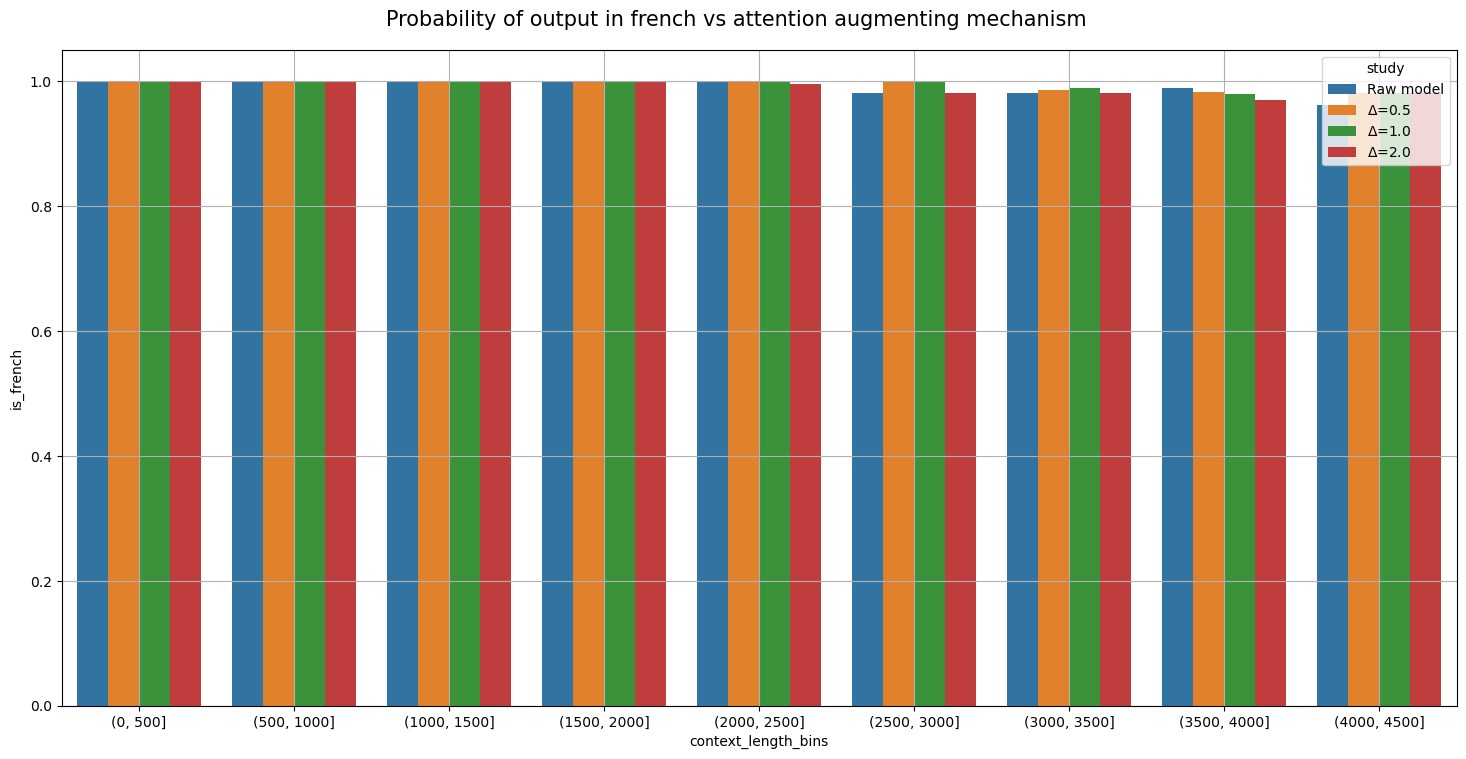

In [15]:
performance_per_index_per_instruction = (all_results_without5)\
    .groupby(["context_length_bins", "study"])\
    .is_french\
    .mean()\
    .reset_index()

plt.figure(figsize = (18,8))

sns.barplot(
    performance_per_index_per_instruction,
    y = "is_french",
    x = "context_length_bins",
    hue = "study",
    hue_order= hue_order
)

plt.grid()
plt.suptitle(rf"Probability of output in french vs attention augmenting mechanism",
             fontsize=  15)
# plt.title(
#     f'''Setup: 
#         {20} different texts per chunk of context length, 
#         {3} instructions, 
#         {10} generations each
#         max_new_tokens =200
#     ''',
#     fontsize = 8
# )

plt.xlim([-.5, 8.5])
plt.subplots_adjust(top = 0.93)

In [16]:
hue_order = (all_results_df)['study'].unique()
hue_order = sorted(
    hue_order, 
    key = lambda x: r"$\Beta$" if x.startswith("Raw") else x,
)    

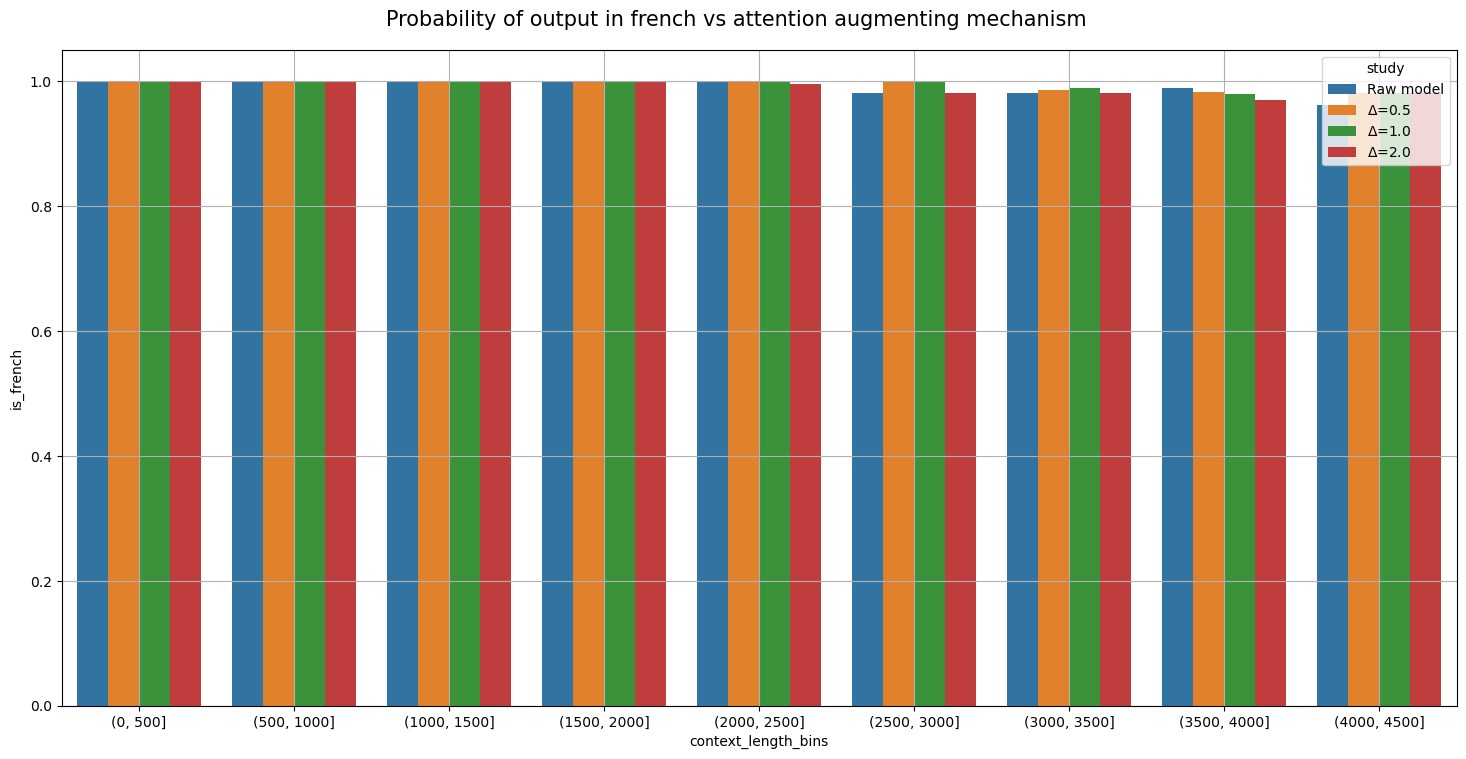

In [17]:
performance_per_index_per_instruction = (all_results_df)\
    .groupby(["context_length_bins", "study"])\
    .is_french\
    .mean()\
    .reset_index()

plt.figure(figsize = (18,8))

sns.barplot(
    performance_per_index_per_instruction,
    y = "is_french",
    x = "context_length_bins",
    hue = "study",
    hue_order= hue_order
)

plt.grid()
plt.suptitle(rf"Probability of output in french vs attention augmenting mechanism",
             fontsize=  15)
# plt.title(
#     f'''Setup: 
#         {20} different texts per chunk of context length, 
#         {3} instructions, 
#         {10} generations each
#         max_new_tokens =200
#     ''',
#     fontsize = 8
# )

plt.xlim([-.5, 8.5])
plt.subplots_adjust(top = 0.93)

## Analysing the generated text

### BERT-Score

## Analysing target summaries

In [ ]:
base_path = "data/generated_text_llm"

targets= dict()

for model_name in os.listdir(base_path):
    path = os.path.join(base_path, model_name, "generated_text.pkl")

    df = pd.read_pickle(path)

    targets[model_name] = df

### Analysing BERT-scores of targets 

In [ ]:
scorer = BERTScorer(model_type = "almanach/camembert-base", num_layers = 12, device='cuda')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
def get_bert_score(x):
    P,R, F1 = scorer.score([x['text']], [x['generated_text']])
    return F1.item()

for k, generated_df in targets.items():

    generated_df['bert_score']=generated_df.apply(get_bert_score, axis =1)
    generated_df['model_name'] = k


In [ ]:
targets_df= pd.concat(targets.values())
targets_df['is_french'] = targets_df['generated_text']\
    .apply(is_text_in_language, language = 'fr')

In [ ]:
targets_df['is_french'].all()

True

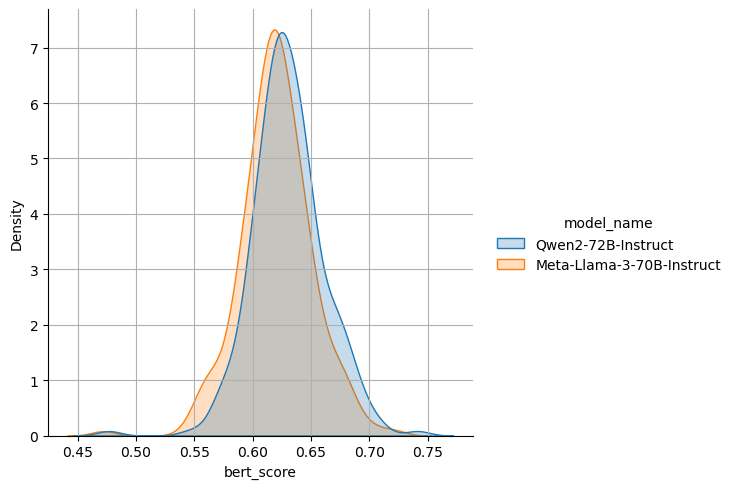

In [ ]:
sns.displot(
    targets_df,
    x = 'bert_score',
    hue = "model_name",
    kind = 'kde',
    fill = True
)
plt.grid()

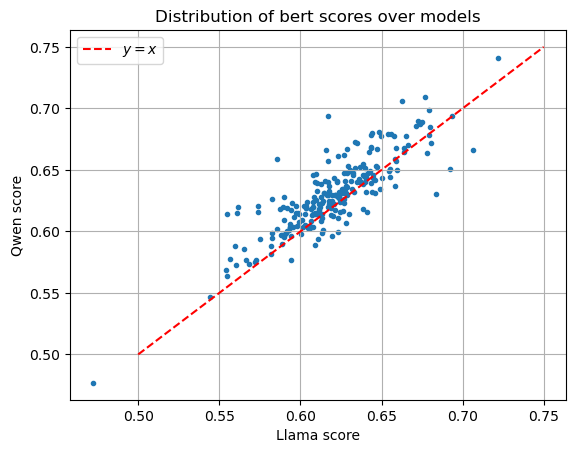

In [ ]:
joint_bert_scores = targets_df.groupby('text_idx')\
    .apply(lambda x: [
        x[x['model_name'].str.contains("Llama")].bert_score,
        x[x['model_name'].str.contains("Qwen")].bert_score
    ])

joint_bert_scores = np.array(list(joint_bert_scores))
plt.scatter(
    joint_bert_scores[:,0], 
    joint_bert_scores[:,1],
    marker = '.'
)

x = np.linspace(0.5, 0.75, 100)

plt.plot(x, x, color = 'red', linestyle = '--', label = '$y=x$')
plt.xlabel("Llama score")
plt.ylabel("Qwen score")

plt.title("Distribution of bert scores over models")
plt.legend()
plt.grid()

In [ ]:
targets_df.is_french.all()

True

In [ ]:
def get_bert_score(x):
    text1 = x.iloc[0]
    text2 = x.iloc[1]

    p, r ,f1 = scorer.score([text1], [text2])

    return f1.item()

In [ ]:
targets_df

,generated_text,text,text_idx,bert_score,model_name,is_french
0,La partition du Québec fait référence à la séc...,The partition of Quebec refers to the secessio...,134,0.597779,Qwen2-72B-Instruct,True
1,"Dans un discours provocateur, un intervenant a...",Everything you know about ARGs is WRONG 22 Dec...,9341,0.617974,Qwen2-72B-Instruct,True
2,L'addiction à la méta est hors de contrôle aux...,Cyrstal Meth Addiction\n\nCrystal meth addicti...,2973,0.597187,Qwen2-72B-Instruct,True
3,"Thích Quảng Đức, né Lâm Văn Túc en 1897 et mor...",Quảng Đức is descriptive of meritorious attrib...,8280,0.645760,Qwen2-72B-Instruct,True
4,"Le spectacle politique mondial de l'année, voi...","World Electioneering Entertainment 2016: 1,000...",3921,0.617735,Qwen2-72B-Instruct,True
...,...,...,...,...,...,...
235,"Voici un résumé du texte en français, dans les...",A New Zealand firm says it successfully triall...,7394,0.640004,Meta-Llama-3-70B-Instruct,True
236,"Voici un résumé du texte en français, dans une...",Originally Posted by Faizan Lakhani Originally...,6932,0.692169,Meta-Llama-3-70B-Instruct,True
237,"À Davao City, aux Philippines, les résidents d...","DAVAO CITY, Philippines — Residents who are 18...",3943,0.636937,Meta-Llama-3-70B-Instruct,True
238,Lorsque la rhétorique de la droite tourne viol...,WHEN THE RIGHT’S RHETORIC TURNS VIOLENT…. In t...,4922,0.621255,Meta-Llama-3-70B-Instruct,True


In [ ]:
scores_between_generations = targets_df.groupby("text")\
    .generated_text\
    .apply(get_bert_score)

In [ ]:
scores_between_generations.rename("bert_score")\
    .reset_index()

,text,bert_score
0,"""Lady Sarah Spencer"" redirects here. For other...",0.813624
1,"(Munroe Falls, Ohio release) – Defending two-t...",0.832150
2,(Photo: via Shutterstock )\n\nA world without ...,0.792587
3,(UPDATED) 'Ang nangyari kasi sa police – 'yung...,0.820580
4,16th October 2016\n\nThe world's first nation ...,0.828069
...,...,...
235,statigr.am/kimbo_ks13 A study by three scienti...,0.872591
236,written by Jennifer Warnick Unique Microsoft h...,0.797893
237,"“God’s Plan for Families,” Ensign, July 2015, ...",0.829787
238,"“We are taking the heat from both sides,” Geha...",0.762336


0.7969423048198223

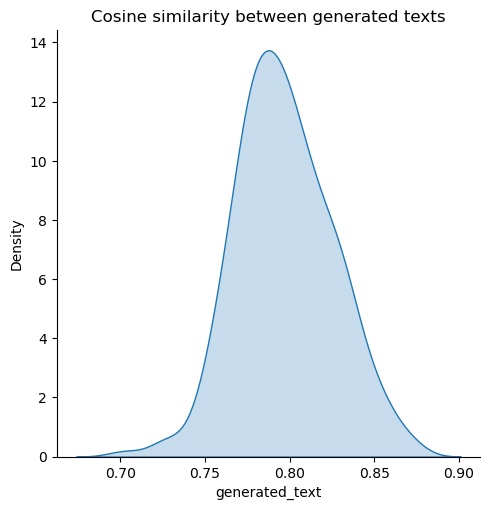

In [ ]:
sns.displot(
    scores_between_generations,
    kind = 'kde',
    fill= True
)

plt.title("Cosine similarity between generated texts")

scores_between_generations.mean()

## Calculating Bert scores of our generations - Llama3 70B


In [ ]:
our_generations_df = pd.concat(all_results)
llm_generations_df = targets['Meta-Llama-3-70B-Instruct']\
    .rename(columns = {"generated_text" : "target_text"})

In [ ]:
complete_df = pd.merge(
    left = our_generations_df,
    right=llm_generations_df[["target_text", "text", "text_idx"]],
    right_on= "text_idx",
    left_on="index",
    how = 'inner'
).query("context_length <= 4500")


In [ ]:
tqdm.pandas()
p, r, f1 = scorer.score(
    complete_df['generated_text'].to_list(), 
    complete_df['target_text'].to_list(),
    batch_size = 64    
)



In [ ]:
complete_df['bert-scores'] = f1.numpy()

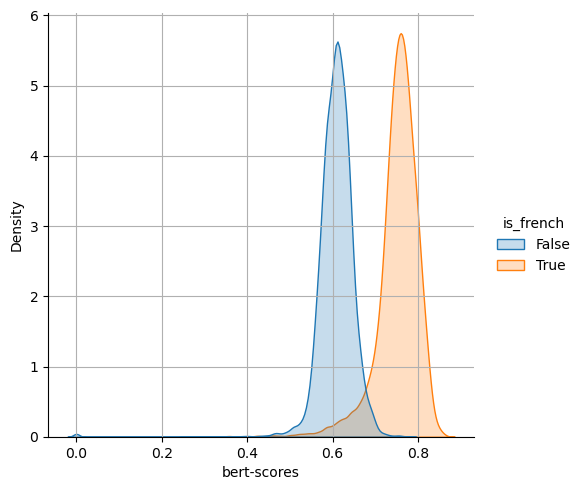

In [ ]:
sns.displot(
    complete_df,
    x = 'bert-scores',
    hue = 'is_french',
    kind='kde',
    fill = 'True',
)


# plt.title("Bert scores distribution")
plt.grid()

In [ ]:
hue_order = complete_df['study'].unique()
hue_order = sorted(
    hue_order, 
    key = lambda x: r"$\Beta$" if x.startswith("Raw") else x,
)    

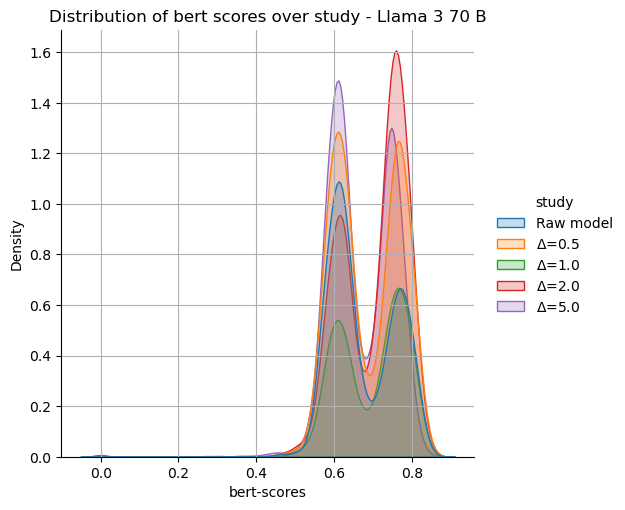

In [ ]:
sns.displot(
    complete_df,
    x = 'bert-scores',
    hue = 'study',
    kind='kde',
    hue_order=hue_order,
    fill = 'True',
    # palette = 'rocket'
)

plt.title("Distribution of bert scores over study - Llama 3 70 B")

plt.grid()

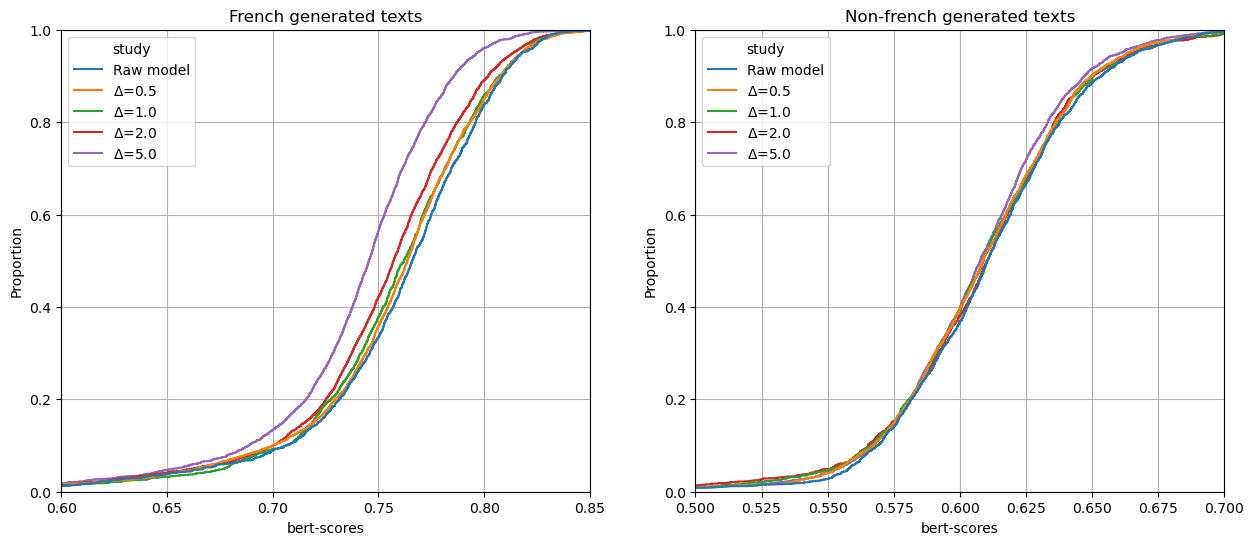

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))
sns.ecdfplot(
    complete_df.query("is_french == 1"),
    x = 'bert-scores',
    hue = 'study',
    hue_order=hue_order,
    # fill = 'True',
    ax= axs[0],
)
axs[0].set_title("French generated texts") 
axs[0].grid(True)
sns.move_legend(axs[0], 'upper left')
axs[0].set_xlim([.6,.85])

sns.ecdfplot(
    complete_df.query("is_french == 0"),
    x = 'bert-scores',
    hue = 'study',
    hue_order=hue_order,
    # fill = 'True',
    ax = axs[1],
)
axs[1].set_title("Non-french generated texts") 
axs[1].grid(True)
axs[1].set_xlim([0.5, .7])

sns.move_legend(axs[1], 'upper left')

# fig.suptitle("Distribution of bert scores - Llama 70B targets")

plt.show()

In [ ]:
raw_model_performance = complete_df.query(f"study == 'Raw model' & is_french == 1")

In [ ]:
# fig, axs = plt.subplots(2, 2, figsize=(16, 12))
study_winning_rates = dict()

for i, study_name in enumerate(complete_df.study.unique()):
    if study_name == 'Raw model':
        continue
    
    clear_output()
    print(f"comparing french text generated by {study_name} to raw model")

    winning_dict = dict()
    
    augmented_model_performance = complete_df.query(f"study == '{study_name}' & is_french == 1")

    for idx, row in tqdm(augmented_model_performance.iterrows(), total = len(augmented_model_performance)):
        bert_scores = row['bert-scores']
        text_idx = row['index']
        winning_dict[idx] = raw_model_performance.query(f"index == {text_idx}")['bert-scores'] < bert_scores

    winning_rate_df = pd.DataFrame(winning_dict)
    winning_rate_df.index.name = "Raw model"
    winning_rate_df.columns.name = study_name

    study_winning_rates[study_name] = winning_rate_df

#     j = (i-1) // 2
#     k = (i-1) % 2
#     sns.heatmap(winning_rate_df, cmap='viridis' ,ax= axs[j][k])
#     axs[j][k].set_title(f"Winning matrix of sutdy : {study_name} - winning_rate = {round(winning_rate_df.mean().mean(),2)}")


# fig.subplots_adjust(hspace=0.3)

comparing french text generated by $\Delta$=5.0, all_layers to raw model


100%|██████████| 1793/1793 [00:03<00:00, 567.06it/s]


In [ ]:
for study, winning_rate in study_winning_rates.items():
    study_winning_rates[study] = (winning_rate).mean().mean()

In [ ]:
pd.Series(study_winning_rates)

$\Delta$=0.5, all_layers    0.505480
$\Delta$=1.0, all_layers    0.507023
$\Delta$=2.0, all_layers    0.488612
$\Delta$=5.0, all_layers    0.349679
dtype: float64

```
winning_rate_df[i][j] = text i from study has a higher bert score than text j from raw model
```

### Calculating BERT Scores of our generations - Qwen 72B

In [ ]:
our_generations_df = pd.concat(all_results)
llm_generations_df = targets['Qwen2-72B-Instruct']\
    .rename(columns = {"generated_text" : "target_text"})

In [ ]:
complete_df = pd.merge(
    left = our_generations_df,
    right=llm_generations_df[["target_text", "text", "text_idx"]],
    right_on= "text_idx",
    left_on="index",
    how = 'inner'
).query("context_length <= 4500")


In [ ]:
tqdm.pandas()
p, r, f1 = scorer.score(
    complete_df['generated_text'].to_list(), 
    complete_df['target_text'].to_list(),
)

complete_df['bert-scores'] = f1

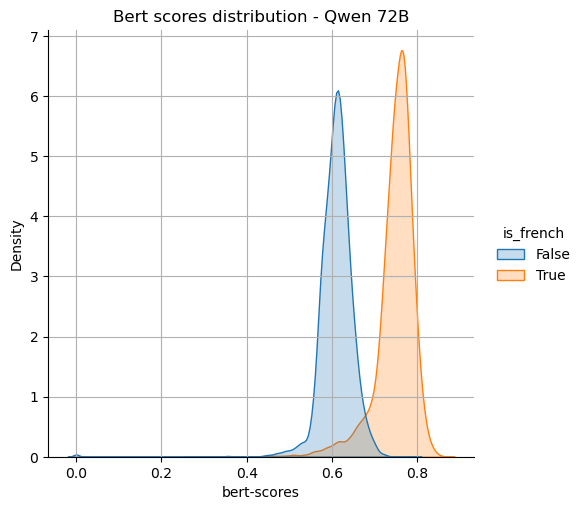

In [ ]:
sns.displot(
    complete_df,
    x = 'bert-scores',
    hue = 'is_french',
    kind='kde',
    fill = 'True',
)


plt.title("Bert scores distribution - Qwen 72B")
plt.grid()

In [ ]:
hue_order = complete_df['study'].unique()
hue_order = sorted(
    hue_order, 
    key = lambda x: "a"+ x[::-1] if x.endswith("y") else "a" if x.startswith("Raw") else x[::-1],
)    

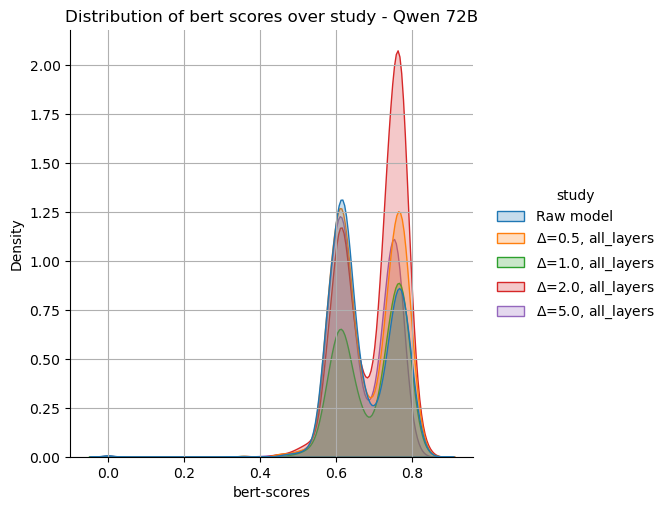

In [ ]:
sns.displot(
    complete_df,
    x = 'bert-scores',
    hue = 'study',
    kind='kde',
    hue_order=hue_order,
    fill = 'True',
    # palette = 'rocket'
)

plt.title("Distribution of bert scores over study - Qwen 72B")

plt.grid()

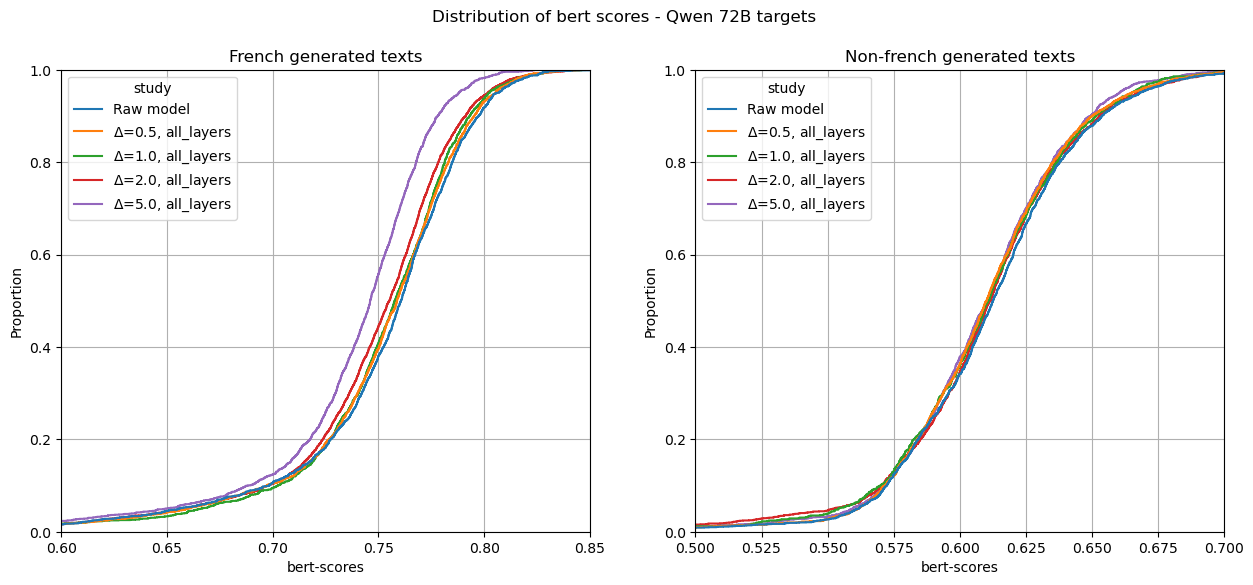

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))
sns.ecdfplot(
    complete_df.query("is_french == 1"),
    x = 'bert-scores',
    hue = 'study',
    hue_order=hue_order,
    # fill = 'True',
    ax= axs[0],
)
axs[0].set_title("French generated texts") 
axs[0].grid(True)
sns.move_legend(axs[0], 'upper left')
axs[0].set_xlim([.6,.85])

sns.ecdfplot(
    complete_df.query("is_french == 0"),
    x = 'bert-scores',
    hue = 'study',
    hue_order=hue_order,
    # fill = 'True',
    ax = axs[1],
)
axs[1].set_title("Non-french generated texts") 
axs[1].grid(True)
axs[1].set_xlim([0.5, .7])

sns.move_legend(axs[1], 'upper left')

fig.suptitle("Distribution of bert scores - Qwen 72B targets")

plt.show()

In [ ]:
raw_model_performance = complete_df.query(f"study == 'Raw model' & is_french == 1")

In [ ]:
# fig, axs = plt.subplots(2, 2, figsize=(16, 12))
study_winning_rates = dict()

for i, study_name in enumerate(complete_df.study.unique()):
    if study_name == 'Raw model':
        continue

    
    clear_output()
    print(f"comparing french text generated by {study_name} to raw model")
    winning_dict = dict()
    
    augmented_model_performance = complete_df.query(f"study == '{study_name}' & is_french == 1")

    for idx, row in tqdm(augmented_model_performance.iterrows(), total = len(augmented_model_performance)):
        bert_scores = row['bert-scores']
        text_idx = row['index']
        winning_dict[idx] = raw_model_performance.query(f"index == {text_idx}")['bert-scores'] < bert_scores

    winning_rate_df = pd.DataFrame(winning_dict)
    winning_rate_df.index.name = "Raw model"
    winning_rate_df.columns.name = study_name

    study_winning_rates[study_name] = winning_rate_df

#     j = (i-1) // 2
#     k = (i-1) % 2
#     sns.heatmap(winning_rate_df, cmap='viridis' ,ax= axs[j][k])
#     axs[j][k].set_title(f"Winning matrix of sutdy : {study_name} - winning_rate = {round(winning_rate_df.mean().mean(),2)}")


# fig.subplots_adjust(hspace=0.3)

comparing french text generated by $\Delta$=5.0, all_layers to raw model


100%|██████████| 1793/1793 [00:03<00:00, 566.62it/s]
